In [ ]:
# ## Edge cell update
# # %% Loading libraries
# from pathlib import Path
# import pandas as pd
# import numpy as np
# import platform
# print('Libraries loaded')

# # %% Load
# if platform.system() == "Windows":
#     org_manifest = Path('Z:\\modeling\\VariancePlayground\\orgmanifests\\variance_dataset_07072022.csv')
#     new_manifest = Path('Z:\\modeling\\VariancePlayground\\orgmanifests\\variance_dataset_07082022.csv')
#     save_manifest = Path('Z:\\modeling\\VariancePlayground\\orgmanifests\\updatedEDGEcalls_22020914.csv')
# elif platform.system() == "Linux":
#     org_manifest = Path('/allen/aics/modeling/VariancePlayground/orgmanifests/variance_dataset_07072022.csv')
#     new_manifest = Path('/allen/aics/modeling/VariancePlayground/orgmanifests/variance_dataset_07082022.csv')
#     save_manifest = Path('/allen/aics/modeling/VariancePlayground/orgmanifests/updatedEDGEcalls_22020914.csv')
# org_cells = pd.read_csv(org_manifest)
# new_cells = pd.read_csv(new_manifest)

# # %% Merge
# selected_columns = ['CellId', 'edge_flag']
# org_cells = org_cells[selected_columns]
# new_cells = new_cells[selected_columns]
# org_cells = org_cells.rename(columns={'edge_flag': 'edge_flag_OLDandWRONG'})
# new_cells = new_cells.rename(columns={'edge_flag': 'edge_flag_NEWandCORRECT'})
# cells = new_cells.merge(org_cells,how='left',on='CellId')
# # %% Checks
# print(len(cells))
# print(sum(cells['edge_flag_OLDandWRONG']==1))
# print(sum(cells['edge_flag_NEWandCORRECT']==1))
# print(sum(np.logical_and(cells['edge_flag_OLDandWRONG']==1,cells['edge_flag_NEWandCORRECT']==1)))

# # %% Save
# cells.to_csv(save_manifest)

In [1]:
import os
os.environ["FSSPEC_CONFIG_DIR"] = "/allen/aics/assay-dev/users/Alex/cytodata/fsspec.d"

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbvv
from upath import UPath as Path
from aicsimageio import AICSImage
from ome_zarr.reader import Reader
from ome_zarr.io import parse_url
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)

## The hiPSC Single-Cell Image Dataset
Our dataset consists of 3D live-cell images of *normal human induced pluripotent stem cells (hiPSCs)*, which are a useful human cell model system. The dataset includes 25 cell lines representing fluorescently tagged major organelles, cellular structures, and compartments. Images of these cells were obtained in 3D using spinning-disk confocal microscopes and were further processed using deep learning-based segmentation. 

<img src="resources/hipsc_single_cell_image_dataset_summary.png"/>

We can read in a table containing the genes, proteins a description of their function as well as the their cellular localization and the specific structure that the protein marks.

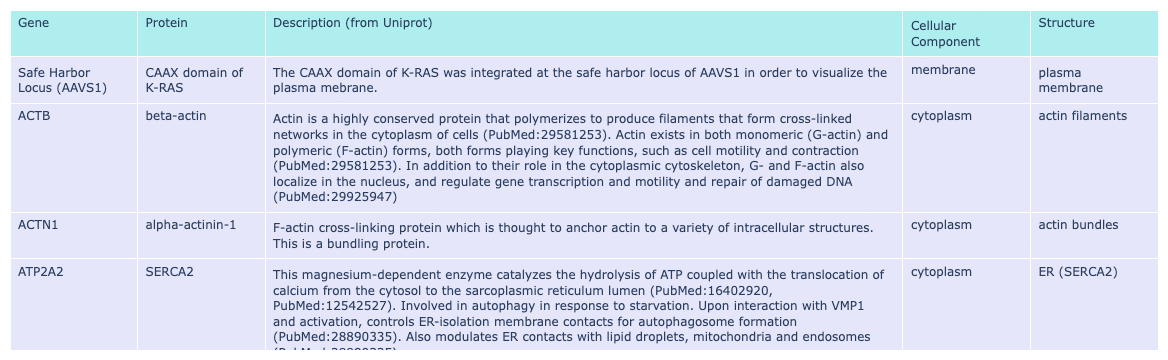

In [15]:
import plotly.graph_objects as go
cell_line_anno = pd.read_csv("resources/cell_line_annotation.txt",delimiter="\t")

fig_tab = go.Figure(
    data=[go.Table(
        columnwidth=[80,80,400,80,80],
        header=dict(values=list(cell_line_anno.columns),
            fill_color='paleturquoise',
            align = 'left'),
        cells=dict(values=[cell_line_anno.Gene,cell_line_anno.Protein,cell_line_anno['Description (from Uniprot)'],cell_line_anno['Cellular Component'],cell_line_anno.Structure],
                   fill_color='lavender',
                   align='left'))

    ]
)
fig_tab.update_layout(
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=4
    ),
)
fig_tab.show()

## From FOVs to single-cell images
The hiPSC Single-Cell Image dataset consists of **215,081** single-cell images which were extracted from **18,100** fields of view (FOVs) of our cell colonies 

In [2]:
# Read the dataset
df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")

Each row of the data frame represents a cell while the columns contain paths to images, metrics, and metadata.

In [3]:
df.shape

(215081, 1242)

In [3]:
some_cell = df.sample(1).iloc[0]
fov_img = AICSImage(some_cell["fov_path"]).data.squeeze()
fov_img.shape

/home/nick.gomez/.cache/pypoetry/virtualenvs/cytodata-aics-fFmiITCU-py3.8/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


(7, 65, 624, 924)

In [12]:
fov_seg_img = AICSImage(some_cell["fov_seg_path"]).data.squeeze()

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


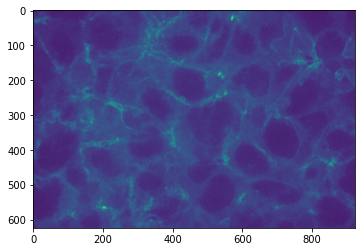

In [13]:
plt.imshow(fov_img[3,30,:,:])

Above is a z-slice (z=30) of an example FOV. We see the cell boundaries of a particular region of a colony. This image of tightly-packed hiPSCs demonstrates the challenge of obtaining single-cell images and motivates the need for the highly accurate 3D deep learned-based cell and nuclear segmentation methods we developed.

In [ ]:
#TODO: display bounding box around `some_cell`
# some_cell['bbox_min_x'], some_cell['bbox_min_y'], some_cell['bbox_max_x'], some_cell['bbox_max_y']

In [4]:
#packages needed 
#!pip install plotly
#!pip install jupyter-dash # need to rebuild jupyter

Looking in indexes: https://artifactory.corp.alleninstitute.org/artifactory/api/pypi/pypi-virtual/simple


# Code to Update manifest - To be deleted

In [3]:
df.shape

(215081, 1242)

## Remove the spherical harmonics coeffs, success

In [21]:
df_filt = df[df.columns.drop(list(df.filter(regex='shcoeffs')))]

In [22]:
df_filt.shape

(215081, 86)

## Remove columns with paths to isilon

In [23]:
df_filt = df_filt.drop(columns=['success','roi','crop_raw','crop_seg','name_dict','fov_path','fov_seg_path','struct_seg_path'])

In [24]:
df_filt.shape

(215081, 78)

In [25]:
df_filt.columns.tolist()

['CellId',
 'structure_name',
 'this_cell_nbr_complete',
 'this_cell_nbr_dist_2d',
 'scale_micron',
 'edge_flag',
 'FOVId',
 'this_cell_index',
 'PlateId',
 'WellId',
 'cell_stage',
 'InstrumentId',
 'WorkflowId',
 'ProtocolId',
 'PiezoId',
 'ChannelNumberStruct',
 'ChannelNumberBrightfield',
 'ChannelNumber405',
 'ChannelNumber638',
 'meta_fov_position',
 'meta_imaging_mode',
 'meta_fov_outside_overview',
 'meta_fov_xcoord',
 'meta_fov_ycoord',
 'meta_fov_edgedist',
 'meta_colony_label',
 'meta_colony_centroid',
 'meta_colony_area',
 'meta_plate_bad_segmentation',
 'meta_plate_confluency',
 'meta_well_passage_at_imaging',
 'meta_well_passage_at_thaw',
 'outlier',
 'NUC_shape_volume',
 'NUC_position_depth',
 'NUC_roundness_surface_area',
 'MEM_shape_volume',
 'MEM_position_depth',
 'MEM_roundness_surface_area',
 'STR_shape_volume',
 'STR_connectivity_cc',
 'NUC_MEM_PC1',
 'NUC_MEM_PC2',
 'NUC_MEM_PC3',
 'NUC_MEM_PC4',
 'NUC_MEM_PC5',
 'NUC_MEM_PC6',
 'NUC_MEM_PC7',
 'NUC_MEM_PC8',
 'an

In [26]:
## Rename columns

new_names = {
    "structure_name":"gene",
    "outlier":"outlier",
    "NUC_shape_volume":"nuclear_volume",
    "NUC_position_depth":"nuclear_height",
    "NUC_roundness_surface_area":"nuclear_surface_area",
    "MEM_shape_volume":"cell_volume",
    "MEM_position_depth":"cell_height",
    "MEM_roundness_surface_area":"cell_surface_area",
    "STR_shape_volume":"structure_volume",
    "STR_connectivity_cc":"structure_connected_components",
    "NUC_MEM_PC1":"shape_feature_1_height",
    "NUC_MEM_PC2":"shape_feature_2_volume",
    "NUC_MEM_PC3":"shape_feature_3_major_tilt",
    "NUC_MEM_PC4":"shape_feature_4_minor_tilt",
    "NUC_MEM_PC5":"shape_feature_5_elongation",
    "NUC_MEM_PC6":"shape_feature_6_bean-ness",
    "NUC_MEM_PC7":"shape_feature_7_pear-ness",
    "NUC_MEM_PC8":"shape_feature_8_wedge",
}

df_filt.rename(columns = new_names,inplace=True)
df_filt.columns.tolist()

['CellId',
 'gene',
 'this_cell_nbr_complete',
 'this_cell_nbr_dist_2d',
 'scale_micron',
 'edge_flag',
 'FOVId',
 'this_cell_index',
 'PlateId',
 'WellId',
 'cell_stage',
 'InstrumentId',
 'WorkflowId',
 'ProtocolId',
 'PiezoId',
 'ChannelNumberStruct',
 'ChannelNumberBrightfield',
 'ChannelNumber405',
 'ChannelNumber638',
 'meta_fov_position',
 'meta_imaging_mode',
 'meta_fov_outside_overview',
 'meta_fov_xcoord',
 'meta_fov_ycoord',
 'meta_fov_edgedist',
 'meta_colony_label',
 'meta_colony_centroid',
 'meta_colony_area',
 'meta_plate_bad_segmentation',
 'meta_plate_confluency',
 'meta_well_passage_at_imaging',
 'meta_well_passage_at_thaw',
 'outlier',
 'nuclear_volume',
 'nuclear_height',
 'nuclear_surface_area',
 'cell_volume',
 'cell_height',
 'cell_surface_area',
 'structure_volume',
 'structure_connected_components',
 'shape_feature_1_height',
 'shape_feature_2_volume',
 'shape_feature_3_major_tilt',
 'shape_feature_4_minor_tilt',
 'shape_feature_5_elongation',
 'shape_feature_6

## Add the cell line annotation 

In [27]:
cell_line_anno.head()

Gene               Protein  \
0  Safe Harbor Locus (AAVS1)  CAAX domain of K-RAS   
1                       ACTB            beta-actin   
2                      ACTN1       alpha-actinin-1   
3                     ATP2A2                SERCA2   
4                      CETN2             centrin-2   

                          Description (from Uniprot) Cellular Component  \
0  The CAAX domain of K-RAS was integrated at the...           membrane   
1  Actin is a highly conserved protein that polym...          cytoplasm   
2  F-actin cross-linking protein which is thought...          cytoplasm   
3  This magnesium-dependent enzyme catalyzes the ...          cytoplasm   
4  Plays a fundamental role in microtubule organi...          cytoplasm   

         Structure  
0  plasma membrane  
1  actin filaments  
2    actin bundles  
3      ER (SERCA2)  
4       centrioles

In [31]:
df_filt1.head()

CellId    gene  this_cell_nbr_complete  \
0  230741  TOMM20                       1   
1  230745  TOMM20                       1   
2  230746  TOMM20                       0   
3  230748  TOMM20                       0   
4  230754  TOMM20                       0   

                               this_cell_nbr_dist_2d  \
0  [(230745, 112.01229336146552), (230746, 158.51...   
1  [(230741, 112.01229336146552), (230746, 187.55...   
2  [(230741, 158.5175782133776), (230745, 187.555...   
3  [(230741, 115.43538034418327), (230745, 193.90...   
4  [(230757, 195.03496287454146), (230758, 101.72...   

                     scale_micron  edge_flag  FOVId  this_cell_index  \
0  [0.108333, 0.108333, 0.108333]          0      1                1   
1  [0.108333, 0.108333, 0.108333]          0      1                5   
2  [0.108333, 0.108333, 0.108333]          0      1                6   
3  [0.108333, 0.108333, 0.108333]          0      1                8   
4  [0.108333, 0.108333, 0.108333]          0      1               14   

      PlateId  WellId  ...                                   max_projection_y  \
0  3500001004   24822  ...  s3://variance-dataset/max_projection_y/230741....   
1  3500001004   24822  ...  s3://variance-dataset/max_projection_y/230745....   
2  3500001004   24822  ...  s3://variance-dataset/max_projection_y/230746....   
3  3500001004   24822  ...  s3://variance-dataset/max_projection_y/230748....   
4  3500001004   24822  ...  s3://variance-dataset/max_projection_y/230754....   

                                   mean_projection_y  \
0  s3://variance-dataset/mean_projection_y/230741...   
1  s3://variance-dataset/mean_projection_y/230745...   
2  s3://variance-dataset/mean_projection_y/230746...   
3  s3://variance-dataset/mean_projection_y/230748...   
4  s3://variance-dataset/mean_projection_y/230754...   

                                 median_projection_y  \
0  s3://variance-dataset/median_projection_y/2307...   
1  s3://variance-dataset/median_projection_y/2307...   
2  s3://variance-dataset/median_projection_y/2307...   
3  s3://variance-dataset/median_projection_y/2307...   
4  s3://variance-dataset/median_projection_y/2307...   

                                    max_projection_x  \
0  s3://variance-dataset/max_projection_x/230741....   
1  s3://variance-dataset/max_projection_x/230745....   
2  s3://variance-dataset/max_projection_x/230746....   
3  s3://variance-dataset/max_projection_x/230748....   
4  s3://variance-dataset/max_projection_x/230754....   

                                   mean_projection_x  \
0  s3://variance-dataset/mean_projection_x/230741...   
1  s3://variance-dataset/mean_projection_x/230745...   
2  s3://variance-dataset/mean_projection_x/230746...   
3  s3://variance-dataset/mean_projection_x/230748...   
4  s3://variance-dataset/mean_projection_x/230754...   

                                 median_projection_x  \
0  s3://variance-dataset/median_projection_x/2307...   
1  s3://variance-dataset/median_projection_x/2307...   
2  s3://variance-dataset/median_projection_x/2307...   
3  s3://variance-dataset/median_projection_x/2307...   
4  s3://variance-dataset/median_projection_x/2307...   

                                        center_slice  fits_z  fits_y fits_x  
0  s3://variance-dataset/center_slice/230741.ome....    True    True   True  
1  s3://variance-dataset/center_slice/230745.ome....    True    True   True  
2  s3://variance-dataset/center_slice/230746.ome....    True    True   True  
3  s3://variance-dataset/center_slice/230748.ome....    True    True   True  
4  s3://variance-dataset/center_slice/230754.ome....    True    True   True  

[5 rows x 78 columns]

In [41]:
df_filt = pd.merge(df_filt,cell_line_anno, left_on='gene',right_on='Gene')
df_filt = df_filt.drop(columns=['Gene'])

In [ ]:
#TODO Fix the AAVS1 gene and Gene don't have same value for AAVS1 so they wont be added correctly.

In [44]:
df_filt.head() 

CellId    gene  this_cell_nbr_complete  \
0  230741  TOMM20                       1   
1  230745  TOMM20                       1   
2  230746  TOMM20                       0   
3  230748  TOMM20                       0   
4  230754  TOMM20                       0   

                               this_cell_nbr_dist_2d  \
0  [(230745, 112.01229336146552), (230746, 158.51...   
1  [(230741, 112.01229336146552), (230746, 187.55...   
2  [(230741, 158.5175782133776), (230745, 187.555...   
3  [(230741, 115.43538034418327), (230745, 193.90...   
4  [(230757, 195.03496287454146), (230758, 101.72...   

                     scale_micron  edge_flag  FOVId  this_cell_index  \
0  [0.108333, 0.108333, 0.108333]          0      1                1   
1  [0.108333, 0.108333, 0.108333]          0      1                5   
2  [0.108333, 0.108333, 0.108333]          0      1                6   
3  [0.108333, 0.108333, 0.108333]          0      1                8   
4  [0.108333, 0.108333, 0.108333]          0      1               14   

      PlateId  WellId  ...                                  mean_projection_x  \
0  3500001004   24822  ...  s3://variance-dataset/mean_projection_x/230741...   
1  3500001004   24822  ...  s3://variance-dataset/mean_projection_x/230745...   
2  3500001004   24822  ...  s3://variance-dataset/mean_projection_x/230746...   
3  3500001004   24822  ...  s3://variance-dataset/mean_projection_x/230748...   
4  3500001004   24822  ...  s3://variance-dataset/mean_projection_x/230754...   

                                 median_projection_x  \
0  s3://variance-dataset/median_projection_x/2307...   
1  s3://variance-dataset/median_projection_x/2307...   
2  s3://variance-dataset/median_projection_x/2307...   
3  s3://variance-dataset/median_projection_x/2307...   
4  s3://variance-dataset/median_projection_x/2307...   

                                        center_slice fits_z fits_y  fits_x  \
0  s3://variance-dataset/center_slice/230741.ome....   True   True    True   
1  s3://variance-dataset/center_slice/230745.ome....   True   True    True   
2  s3://variance-dataset/center_slice/230746.ome....   True   True    True   
3  s3://variance-dataset/center_slice/230748.ome....   True   True    True   
4  s3://variance-dataset/center_slice/230754.ome....   True   True    True   

   Protein                         Description (from Uniprot)  \
0    Tom20  Central component of the receptor complex resp...   
1    Tom20  Central component of the receptor complex resp...   
2    Tom20  Central component of the receptor complex resp...   
3    Tom20  Central component of the receptor complex resp...   
4    Tom20  Central component of the receptor complex resp...   

   Cellular Component     Structure  
0           cytoplasm  mitochondria  
1           cytoplasm  mitochondria  
2           cytoplasm  mitochondria  
3           cytoplasm  mitochondria  
4           cytoplasm  mitochondria  

[5 rows x 82 columns]

# Column Descriptions

The dataset contains over 1200 columns with important metrics which you may want to incorporate during the challenge. In this section we'll create a tiny dash app that runs within the notebook in order to display an interactive table of the columns and their descriptions. **The table is searchable** lending itself to more efficient querying.

In [3]:
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html
JupyterDash.infer_jupyter_proxy_config()

Read in the data frame with column names and descriptions from our resources folder. #TODO will need to update this with the final list of columns and their descriptions

In [4]:
col_df = pd.read_csv("resources/colname_test.csv",delimiter=":",header=None)
col_df.columns = ["column name","description"]


Create the dash app that will serve the data frame as an interactive table that will allow you to search for specific columns.

In [6]:
from dash import dash_table
app = JupyterDash(__name__)
server = app.server

app.layout = dash_table.DataTable(
    col_df.to_dict('records'), 
    [{"name": i, "id": i} for i in col_df.columns],
    style_data={
        'whiteSpace':'normal',
        'height': 'auto',
        'lineHeight':'15px',
        'backgroundColor': 'rgb(50,50,50)',
        'color': 'white',
    },
    style_header={
        'backgroundColor':'rgb(30,30,30)',
        'color':'white'
    },  
    style_cell={
        'textAlign':'left'
    },
    filter_action="native",
)



In [ ]:
app.run_server(mode="inline", port=8588,) # This runs on a specified port. Either enable port forwarding on your maching. #TODO work with Gui to enable this directly from the app rather than port forwarding. 

Address already in use
Port 8588 is in use by another program. Either identify and stop that program, or start the server with a different port.


# Overview Stats

As seen from above there is a lot of information contained within the manifest. This section just gives a small overview/introduction into the dataset and will be expanded upon in later chapters.

In [8]:
import plotly.express as px # need to get this to the top


The cell images came from over 18K FOVs and we can use the manifest to understand how many FOV's were captured per tagged structure.

In [9]:
fig_fovstruc = px.bar(df.groupby('structure_name').FOVId.nunique(),text_auto=True,title="# of FOV per structure")
fig_fovstruc.update_layout(xaxis=dict(categoryorder="total descending"),overwrite=True)
fig_fovstruc.show()

NameError: name 'df' is not defined

The number of FOVs isn't evenly distributed between the cell lines. In addition, the number of cells in an FOV varies based on position of the colony as well as the confluence of the wells. We can visualize the distribution of cells per FOV using a violin plot. We can parse the dataframe to calculate the number of cells per FOVId grouped by structure and then merge these counts into a new data frame for easy access later. Then wecan visualize using a violin plot.

In [31]:
cells_per_fov = (
    df.groupby('structure_name').FOVId
    .value_counts()
    .to_frame(name="cell_count_per_FOV")
    .reset_index()
    .set_index('FOVId')
    .merge(
        df[['FOVId', 'fov_path']]
        .drop_duplicates(subset=['FOVId'])
        .set_index('FOVId'),
        left_index=True,
        right_index=True
    )
    .reset_index()
)

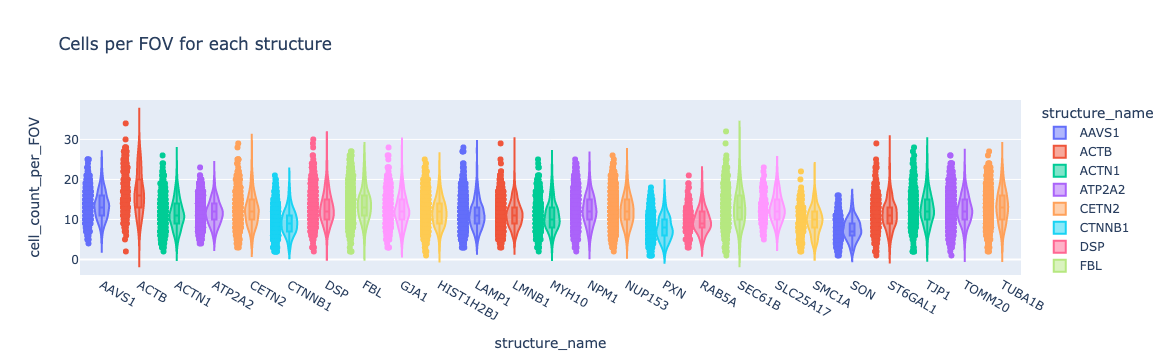

In [33]:
fig_cells_fov = px.violin(
    cells_per_fov,
    x=cells_per_fov.structure_name,
    y=cells_per_fov.cell_count_per_FOV,
    box=True,
    points='all',
    color=cells_per_fov.structure_name,
    hover_data=cells_per_fov.drop(columns=['fov_path']),
    title="Cells per FOV for each structure"
)
fig_cells_fov.show()

Visualizing the data we can see that overall the distribution of the number of cells is consistent through the different cell lines. We can see that it FOV's generally contain between 2 and 20+ cells with a median around 14.  Though the FOV data is not included for the purposes of this task we can still visualize the FOVs as they are publically available data.  First we'll create a simple function that uses the FOVId to identify a Cell ID which we can use in our browser based cell viewer.

In [32]:
def generate_url(FOV_of_interest):
    cell_id = df[df['FOVId']==FOV_of_interest].CellId.tolist()[0]
    print(f"Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id={FOV_of_interest} and select the Full Field at the top of the screen")

We can hover the data from the violin plot above and select the highest point within the **ACTB** scatter plot and see that the **FOVID is 5785**. We'll use this to look at an FOV with 34 cells! 

In [33]:
FOV_of_interest = 5785 # Enter FOV of interest in this case 5785 which comes from the max number of cells of of ACTB
generate_url(FOV_of_interest)

Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id=5785 and select the Full Field at the top of the screen


The dataset consists of over 200K cells and based on the number distribution of FOVs we can assume that they are not evenly spraed across the 25 cell lines. We can visualize the number of cells per structure by further parsing the data frame.

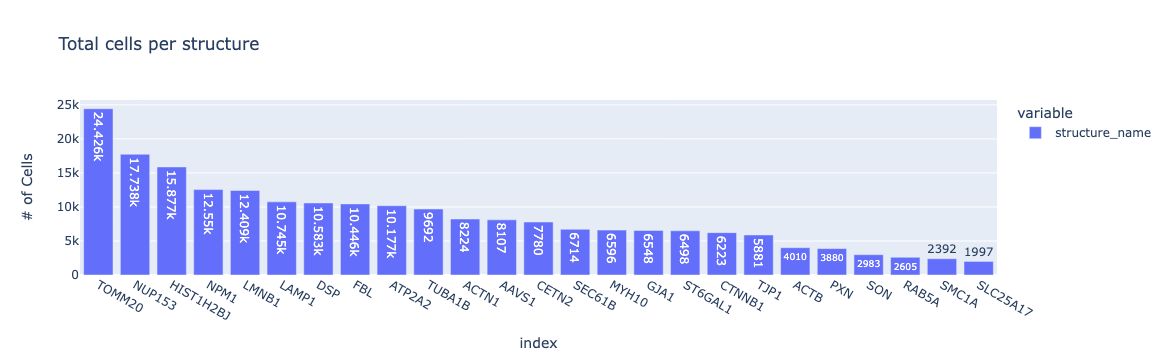

In [19]:
fig_total = px.bar(df.structure_name.value_counts(),text_auto=True,title="Total cells per structure",labels=dict(value="# of Cells"))
fig_total.show()

# OLD  Delete?

In [15]:
def read_ome_zarr(path, level=0, image_name="default"):
    path = str(path if image_name is None else Path(path) / image_name)
    reader = Reader(parse_url(path))

    node = next(iter(reader()))
    pps = node.metadata["coordinateTransformations"][0][0]["scale"][-3:]
   
    return AICSImage(
        node.data[level].compute(),
        channel_names=node.metadata["name"],
        physical_pixel_sizes=pps
    )

def rescale_image(img_data, channels):
    img_data = img_data.squeeze().astype(np.float32)
    
    for ix, channel in enumerate(channels):
        if "_seg" not in channel:
            img_data[ix] -= 1
            
            img_data[ix] = np.where(
                img_data[ix] >= 0,
                img_data[ix] / img_data.max(),
                -1
            )
    return img_data.astype(np.float16)

In [15]:
for axis in list("zyx"):
    print(axis)
    diff_quants = (df[f"bbox_max_{axis}"] - df[f"bbox_min_{axis}"]).quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.990])
    print(diff_quants)

z
0.100     69.0
0.250     79.0
0.500     93.0
0.750    111.0
0.900    127.0
0.950    136.0
0.975    146.0
0.990    156.0
dtype: float64
y
0.100    140.0
0.250    158.0
0.500    180.0
0.750    205.0
0.900    229.0
0.950    245.0
0.975    260.0
0.990    279.0
dtype: float64
x
0.100    212.0
0.250    239.0
0.500    273.0
0.750    313.0
0.900    354.0
0.950    381.0
0.975    406.0
0.990    438.0
dtype: float64


In [6]:
df["success"].value_counts()

True    215081
Name: success, dtype: int64

In [7]:
some_cell = df.sample(1).iloc[0]

In [8]:
full_img = read_ome_zarr(some_cell["registered_path"])

In [9]:
full_img.channel_names

['bf',
 'dna',
 'membrane',
 'structure',
 'dna_segmentation',
 'membrane_segmentation',
 'struct_segmentation_roof']

In [10]:
img_data = full_img.data.squeeze()

In [11]:
img_data.shape

(7, 136, 245, 381)

In [16]:
img_data = rescale_image(img_data, full_img.channel_names)

In [ ]:
img_data.shape

In [16]:
nbvv.volshow(
    img_data,
    spacing=[1,1,1],#full_img.physical_pixel_sizes,
    channel_names=full_img.channel_names
)

VolumeWidget(dimensions={'tile_width': 204, 'tile_height': 136, 'rows': 15, 'cols': 10, 'atlas_width': 2040, '…

In [17]:
print(f"""
Alternatively to `nbvv`, try visiting:
https://toloudis.github.io/website-3d-cell-viewer/?url=https://static-minio.a100.int.allencell.org/variance-dataset/register/{some_cell.CellId}.ome.zarr&image=default
""")


Alternatively to `nbvv`, try visiting:
https://toloudis.github.io/website-3d-cell-viewer/?url=https://static-minio.a100.int.allencell.org/variance-dataset/register/354095.ome.zarr&image=default



In [ ]:
plt.imshow(img_data[1].max(axis=0))
plt.show()

In [16]:
projections = [
    'max_projection_x',
    'max_projection_y',
    'max_projection_z',
    'mean_projection_x',
    'mean_projection_y',
    'mean_projection_z',
    'median_projection_x',
    'median_projection_y',
    'median_projection_z',
    'center_slice'
]

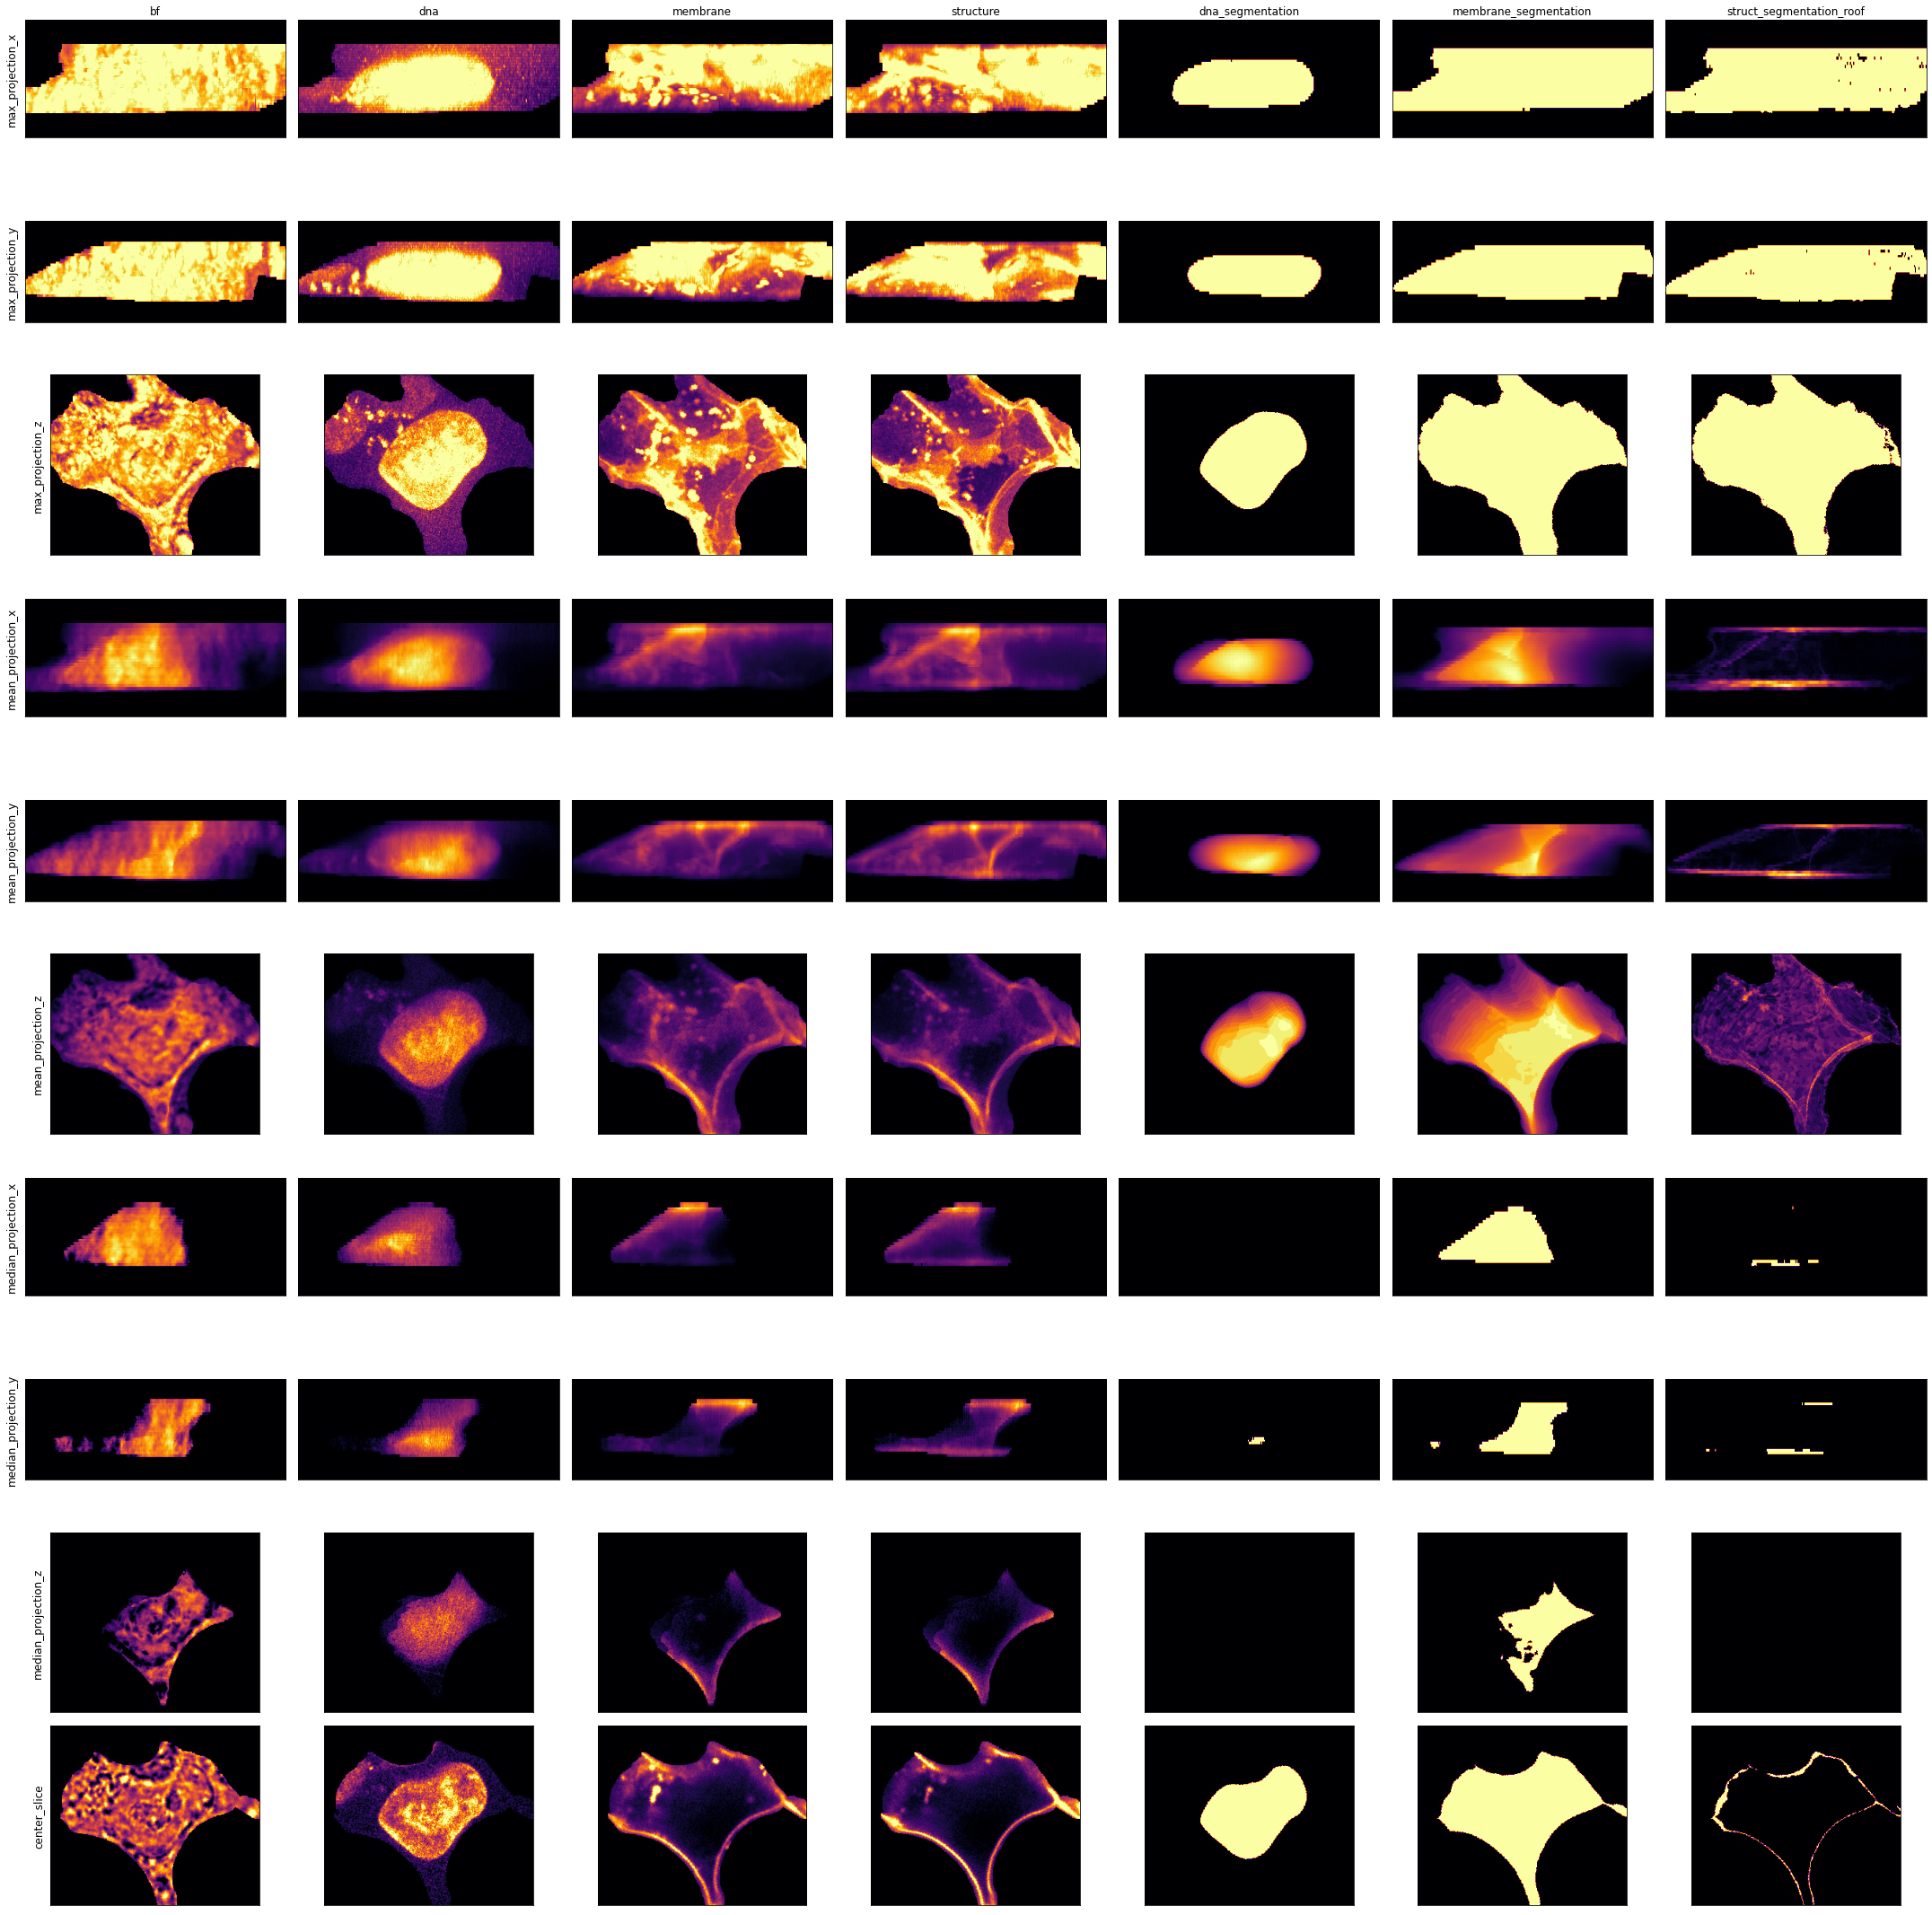

In [43]:
f, axs = plt.subplots(len(projections), 7, figsize=(30, 30))
for proj_ix, projection in enumerate(projections):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        proj = AICSImage(some_cell[projection]).data.squeeze()
    
    for ix, channel in enumerate(full_img.channel_names):
        axs[proj_ix, ix].imshow(proj[ix], cmap="inferno")
        
        if proj_ix == 0:
            axs[proj_ix, ix].set_title(channel, size="large")
        axs[proj_ix, ix].set_xticks([])
        axs[proj_ix, ix].set_yticks([])


    axs[proj_ix, 0].set_ylabel(projection, rotation=90, size='large')

plt.tight_layout()
plt.show()